# Kalman filter strat
Basically attempting to implement this: https://www.reddit.com/r/algotrading/comments/obbb5d/kalman_filter_stat_arb/

With help from: 
https://github.com/welly87/epchanbooks/blob/main/book2/KF_beta_EWA_EWC.py

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [139]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [140]:
# ZECUSDT, BCHUSDT
# XMRUSDT

In [83]:
# df1 = pd.read_csv("../data/testing-hourly/CELRUSDT-minute.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/testing-hourly/FETUSDT-minute.csv", index_col=0, parse_dates=True)

df1 = pd.read_csv("../data/CELRUSDT-past.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/FETUSDT-past.csv", index_col=0, parse_dates=True)

# df1 = pd.read_csv("../data/testing-hourly/BTTUSDT-minute.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/testing-hourly/HOTUSDT-minute.csv", index_col=0, parse_dates=True)

# df1 = pd.read_csv("../data/ZECUSDT-minute.csv", index_col=0, parse_dates=True)
# df2 = pd.read_csv("../data/XMRUSDT-minute.csv", index_col=0, parse_dates=True)

In [87]:
print(len(df1))
print(len(df2))

1214652
1249933


## Using the CADF Test for Cointegration

In [88]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
# df["C"] = df3.close

In [89]:
df = df[4000:]
df = df.dropna()

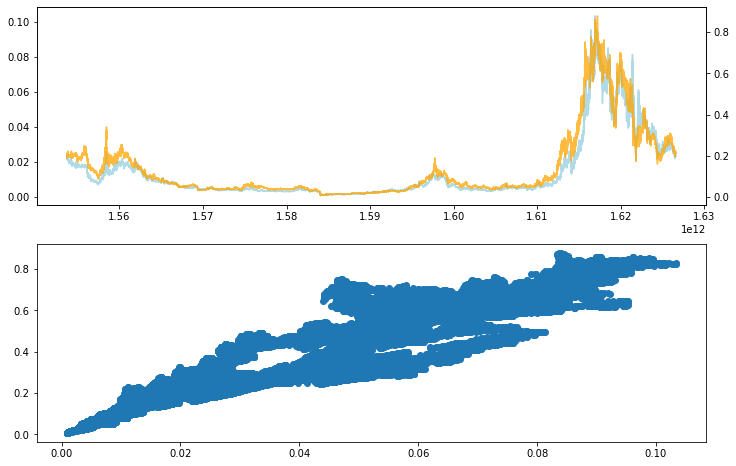

In [90]:
fig, (ax, ax1) = plt.subplots(2, figsize=(12, 8))
ax.plot(df[df.columns[0]], color="lightblue", alpha=.95)
axi = ax.twinx()
axi.plot(df[df.columns[1]], color="orange", alpha=.75)
ax1.scatter(df[df.columns[0]], df[df.columns[1]]);

In [91]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
results.params[1]

8.966791425436664

In [92]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
print(results.params)
hedgeRatio = results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

Intercept    0.011597
A            8.966791
dtype: float64
hedgeRatio=8.966791


<AxesSubplot:xlabel='timestamp'>

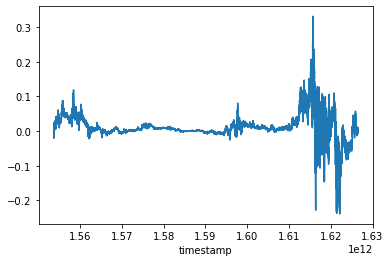

In [93]:
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(2000).mean()
spread["std"] =  spread.spread.rolling(2000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
spread["zscore_std"] =  spread.zscore.rolling(2000).std()
spread["thres"] = spread.zscore_std.map(lambda x: 1. if x<0.5 else np.sqrt(x*2))

spread.spread.plot()

<AxesSubplot:xlabel='timestamp'>

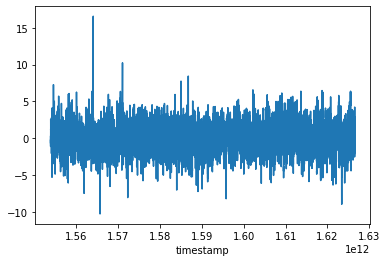

In [94]:
spread.zscore.plot()

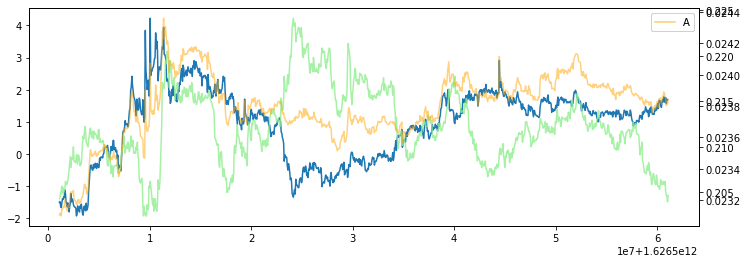

In [95]:
a = -1000
b = -1 #Not None
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(spread.zscore[a:b], alpha=1)
ax1 = ax.twinx()
ax1.plot(df["A"].loc[spread.index[a]:spread.index[b]], label="A", color="lightgreen", alpha=.8)
ax2 = ax.twinx()
ax2.plot(df["B"].loc[spread.index[a]:spread.index[b]], label="A", color="orange", alpha=.5)
ax1.legend()
ax2.legend()

In [96]:
spread = spread.dropna()

In [97]:
spread["A"] = df1["close"].reindex(spread.index)
spread["Ah"] = df1["high"].reindex(spread.index)
spread["Al"] = df1["low"].reindex(spread.index)

spread["B"] = df2["close"].reindex(spread.index)
spread["Bh"] = df2["high"].reindex(spread.index)
spread["Bl"] = df2["low"].reindex(spread.index)

In [98]:
spread

,spread,mean,std,zscore,zscore_std,thres,A,Ah,Al,B,Bh,Bl
timestamp,,,,,,,,,,,,
1553966280000,0.016412,0.013486,0.006604,0.443020,0.809207,1.272169,0.02052,0.02053,0.02052,0.20050,0.20050,0.20050
1553966340000,0.016501,0.013493,0.006600,0.455848,0.808951,1.271967,0.02052,0.02052,0.02052,0.20050,0.20050,0.20050
1553966400000,0.016501,0.013500,0.006595,0.455065,0.808553,1.271655,0.02050,0.02052,0.02050,0.20050,0.20050,0.20050
1553966460000,0.016591,0.013507,0.006591,0.467894,0.808238,1.271407,0.02049,0.02051,0.02049,0.20030,0.20050,0.20000
1553966520000,0.016560,0.013514,0.006587,0.462423,0.807915,1.271153,0.02060,0.02060,0.02040,0.20020,0.20020,0.20020
...,...,...,...,...,...,...,...,...,...,...,...,...
1626560820000,0.006932,0.000040,0.003947,1.745939,1.312314,1.620070,0.02328,0.02328,0.02323,0.21485,0.21541,0.21485
1626560880000,0.006231,0.000044,0.003950,1.566607,1.312687,1.620301,0.02324,0.02326,0.02320,0.21509,0.21512,0.21431
1626560940000,0.006751,0.000048,0.003953,1.696070,1.313103,1.620557,0.02320,0.02323,0.02320,0.21513,0.21513,0.21505


In [99]:
# def get_a_b(al, ac, ah, bl, bc, bh):
#     return random.uniform(al, ac), random.uniform(ac, ah), random.uniform(bl, bc), random.uniform(bc, bh)

def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

# def liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee):
#     """Returns total"""
#     if (long == "A" and not reverse) or (long == "B" and reverse):
#         total = (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
#         total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
#     elif (long == "B" and not reverse) or (long == "A" and reverse):
#         total = (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
#         total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
#     return total

In [104]:
spread.index = (range(len(spread)))

In [111]:
# Buy  random value between high and low, now correct LONG A or B
total = 100.
fee = 0.002       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [45]:
# Buy liquidate after 1 days no matter what
total = 100.
fee = 0.002       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
vb = None
prevent = None
trades = 0
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres and prevent != "B": 
                vb = spread.index[i] + timedelta(1)
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
                prevent = None
            elif z<-thres and prevent != "A":
                vb = spread.index[i] + timedelta(1)
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
                prevent = None
    if (long == "A" and z>sell_thres) or (long=="A" and spread.index[i]>vb): #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
        if vb:
            prevent = "A"
            vb = None
    elif (long == "B" and z<-sell_thres) or (long=="B" and spread.index[i]>vb): #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
        if vb: 
            prevent = "B"
            vb = None
    cusum.append(total)

In [21]:
# CONSTANT TOTAL
total = 100.
fee = 0.002       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((50/2)/ah)*(1.-fee)]
                price_b = [bl, ((50/2)/bl)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((50/2)/al)*(1.-fee)]
                price_b = [bh, ((50/2)/bh)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [382]:
total = 100.
fee = 0.003       #Set double normal rate
thres = 1         #2
sell_thres = 1   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            price_a = [spread.A[i], ((total/2)/spread.A[i])*(1.-fee)]
            price_b = [spread.B[i], ((total/2)/spread.B[i])*(1.-fee)]
            if z>thres: 
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z>sell_thres: #Liquidate positions
        total += mr*(spread.A[i] - price_a[0])*price_a[1]-(spread.A[i]*price_a[1]*fee)
        total += mr*(price_b[0] - spread.B[i])*price_b[1]-(spread.B[i]*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        total += mr*(price_a[0] - spread.A[i])*price_a[1]-(spread.A[i]*price_a[1]*fee)
        total += mr*(spread.B[i] - price_b[0])*price_b[1]-(spread.B[i]*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

In [18]:
# a = df1[1_000_000:]
# a = abs(a.low-a.close)/a.close

In [19]:
# a.mean()

2338302.6169107095


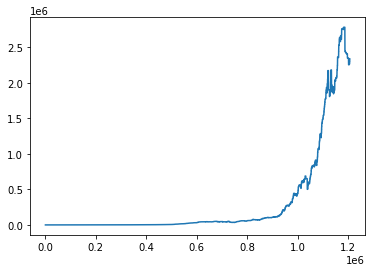

In [112]:
plt.plot(cusum);
print(total)

## Creating side

In [113]:
side_up = pd.Series(1, index=long_a)
side_down = pd.Series(-1, index=long_b)
side = pd.concat([side_up,side_down]).sort_index()
side

262        1
818       -1
1598      -1
1812       1
3628      -1
          ..
1201565    1
1203877   -1
1205768    1
1206037   -1
1206278    1
Length: 1230, dtype: int64

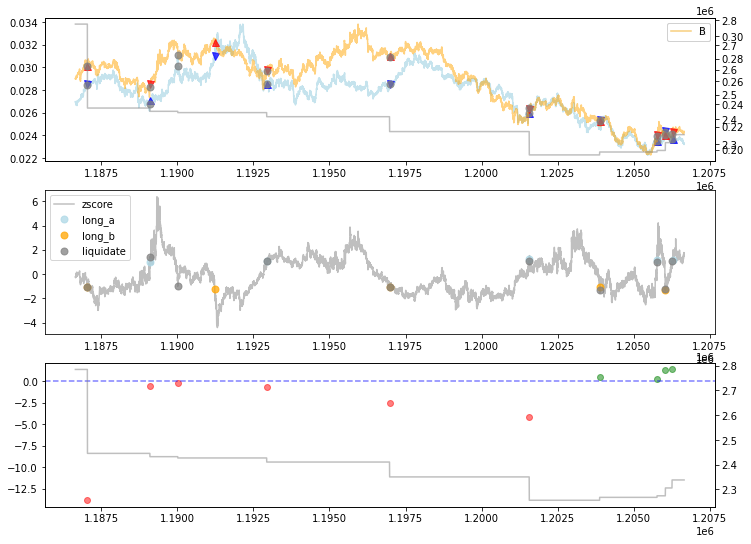

In [116]:
plot = spread
plot["cusum"] = cusum

s = list(pd.Series(cusum).diff())
s = pd.Series(s, index=spread.index)
plot["diffs"] = s[s != 0.]


plot = plot[-20000:] #500_000:700_000

fig, (ax, axz, axc) = plt.subplots(3, figsize=(12,9))

# close_df.loc['2014':].plot(ax=ax, alpha=.5)
ax.plot(plot.A, alpha=.7, color="lightblue", label="A")
ax1 = ax.twinx()
ax1.plot(plot.B, alpha=.5, color="orange", label="B")


ax.plot(plot.A.reindex(long_a), marker='^', markersize=7,
                     alpha=0.75, color='blue', linewidth=0)

ax.plot(plot.A.reindex(long_b), marker='v', markersize=7,
                     alpha=0.75, color='blue', linewidth=0)

ax1.plot(plot.B.reindex(long_b), marker='^', markersize=7,
                     alpha=0.75, color='red', linewidth=0)

ax1.plot(plot.B.reindex(long_a), marker='v', markersize=7,
                     alpha=0.75, color='red', linewidth=0)
ax.plot(plot.A.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, color='gray', linewidth=0)
ax1.plot(plot.B.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, color='gray', linewidth=0)
ax2 = ax.twinx()
ax2.plot(plot.cusum, color="gray", alpha=.5)
ax.legend()
ax1.legend()

axz.plot(plot.zscore, color="gray", alpha=.5, label="zscore")
axz.plot(plot.zscore.reindex(long_a), marker='o', markersize=7,
                     alpha=0.75, label='long_a', color='lightblue', linewidth=0)
axz.plot(plot.zscore.reindex(long_b), marker='o', markersize=7,
                     alpha=0.75, label='long_b', color='orange', linewidth=0)
axz.plot(plot.zscore.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, label='liquidate', color='gray', linewidth=0)

axz.legend()

axc.scatter(plot.index, plot.diffs[plot.diffs > 0].reindex(plot.index)*100/plot.cusum, color="green", alpha=.5)
axc.scatter(plot.index, plot.diffs[plot.diffs <= 0].reindex(plot.index)*100/plot.cusum, color="red", alpha=.5)
axc.axhline(0, linestyle="--", color="blue", alpha=.5)
axc1 = axc.twinx()
axc1.plot(plot.cusum, color="gray", alpha=.5)

In [476]:
plot.diffs[plot.diffs > 0].reindex(plot.index)*100/plot.cusum

timestamp
2021-07-02 15:37:00   NaN
2021-07-02 15:38:00   NaN
2021-07-02 15:39:00   NaN
2021-07-02 15:40:00   NaN
2021-07-02 15:41:00   NaN
                       ..
2021-07-16 12:52:00   NaN
2021-07-16 12:53:00   NaN
2021-07-16 12:54:00   NaN
2021-07-16 12:55:00   NaN
2021-07-16 12:56:00   NaN
Length: 20000, dtype: float64

<AxesSubplot:xlabel='timestamp'>

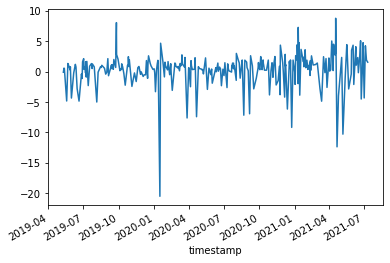

In [42]:
s = list(pd.Series(cusum).diff())
s = pd.Series(s, index=spread.index)
s = s[s != 0.]
s.plot()

In [41]:
s

timestamp
2019-05-05 23:00:00         NaN
2019-05-09 19:00:00   -0.107035
2019-05-11 10:00:00    0.564604
2019-05-12 09:00:00    0.528652
2019-05-18 11:00:00   -4.832214
                         ...   
2021-06-29 11:00:00    1.270078
2021-07-01 13:00:00   -4.332836
2021-07-04 16:00:00    4.232944
2021-07-07 11:00:00    1.873261
2021-07-10 17:00:00    1.540146
Length: 297, dtype: float64

In [489]:
# cadf test
coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print(crit_value)

KeyboardInterrupt: 

### GOOD CADFs
- ETH-XMR: -3.8
- ZEC-XMR: -3.4
- ETH-ADA: -5

In [490]:
# Johansen test
result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[199.85595738   4.26277077]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[195.59318661   4.26277077]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [102]:
# Add IGE for Johansen test
result = vm.coint_johansen(df.values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[29.57270139  2.71300412]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[26.85969727  2.71300412]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [491]:
print(result.eig)  # eigenvalues
print(result.evec)  # eigenvectors

[1.61816728e-04 3.52692355e-06]
[[269.19025662  23.92829479]
 [-29.24700968   3.60031228]]


<AxesSubplot:>

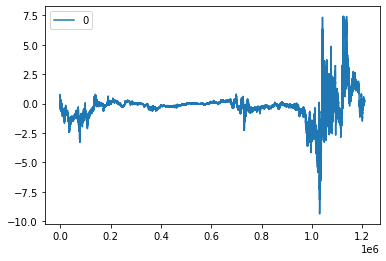

In [492]:
yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
yport.plot()

In [493]:
ylag = yport.shift()
deltaY = yport - ylag
df2 = pd.concat([ylag, deltaY], axis=1)
df2.columns = ['ylag', 'deltaY']
regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()  # Note this can deal with NaN in top row
print(regress_results.params)

Intercept   -0.000092
ylag        -0.000375
dtype: float64


In [494]:
halflife = -np.log(2) / regress_results.params['ylag']
print('halflife=%f days' % halflife)

halflife=1846.180824 days


APR=0.012435 Sharpe=0.436517


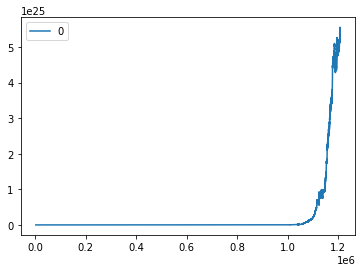

In [495]:
#  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
lookback = np.round(halflife).astype(int)  # setting lookback to the halflife found above
numUnits = -(yport - yport.rolling(lookback).mean()) / yport.rolling(
    lookback).std()  # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions = pd.DataFrame(np.dot(numUnits.values, np.expand_dims(result.evec[:, 0],
                                                                axis=1).T) * df.values)  # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl = np.sum((positions.shift().values) * (df.pct_change().values), axis=1)  # daily P&L of the strategy
ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame((np.cumprod(1 + ret) - 1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1 + ret) ** (252 / len(ret)) - 1, np.sqrt(252) * np.mean(ret) / np.std(ret)))
# APR=0.125739 Sharpe=191310

## Co-integration brute-force tests

In [ ]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [495]:
stats = pd.DataFrame(columns=["A", "B", "t", "p", "h"])

In [496]:
loc = ["BTCUSDT", "ETHUSDT", "DOTUSDT", "ADAUSDT", "LTCUSDT", "ZECUSDT", "XMRUSDT", "ETCUSDT", "XLMUSDT", "BCHUSDT"]

for a in loc:
    for b in loc[loc.index(a)+1:]:
        print(f"========== {a} and {b} ==========")
        df1 = pd.read_csv(f"../data/{a}-hour.csv", index_col=0, parse_dates=True)
        df2 = pd.read_csv(f"../data/{b}-hour.csv", index_col=0, parse_dates=True)
        df = df1.close.rename("A").to_frame()
        df["B"] = df2.close
        df = df[1000:]
        df = df.dropna()
        # cadf test
        coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
        print(f"t-statistic={round(coint_t, 2)}, pvalue={round(pvalue, 2)}, crits={crit_value}")

        result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
        yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
        ylag = yport.shift()
        deltaY = yport - ylag
        df2 = pd.concat([ylag, deltaY], axis=1)
        df2.columns = ['ylag', 'deltaY']
        regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()
        halflife = -np.log(2) / regress_results.params['ylag']
        stats.append({"A":a, "B":b, "t":coint_t, "p":pvalue, "h":halflife}, ignore_index=True)
        print(f'halflife={round(halflife, 0)} days')
stats

========== BTCUSDT and ETHUSDT ==========
t-statistic=-2.4, pvalue=0.33, crits=[-3.89677187 -3.33631514 -3.04457851]
halflife=2197.0 days
========== BTCUSDT and DOTUSDT ==========
t-statistic=-2.97, pvalue=0.12, crits=[-3.8978432  -3.33691266 -3.04499323]
halflife=239.0 days
========== BTCUSDT and ADAUSDT ==========
t-statistic=-2.35, pvalue=0.35, crits=[-3.89682765 -3.33634626 -3.04460011]
halflife=1397.0 days
========== BTCUSDT and LTCUSDT ==========
t-statistic=-3.65, pvalue=0.02, crits=[-3.89679128 -3.33632597 -3.04458603]
halflife=821.0 days
========== BTCUSDT and ZECUSDT ==========
t-statistic=-2.95, pvalue=0.12, crits=[-3.89698287 -3.33643284 -3.04466021]
halflife=472.0 days
========== BTCUSDT and XMRUSDT ==========
t-statistic=-2.67, pvalue=0.21, crits=[-3.89697903 -3.3364307  -3.04465872]
halflife=540.0 days
========== BTCUSDT and ETCUSDT ==========
t-statistic=-3.17, pvalue=0.08, crits=[-3.89684698 -3.33635704 -3.04460759]
halflife=1104.0 days
========== BTCUSDT and XLMUSDT =

,A,B,t,p,h


In [ ]:
# If reach 2 reverse position
total = 100.
fee = 0.002       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
reverse_thres = 2. #Reverse trades if reached here, pretend it's the same trade. 
reverse = False
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
mr = -1           #or 1 for not mean reversion
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z<-reverse_thres and not reverse: #Reverse
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        liquidate.append(spread.index[i])
        
        price_a = [ah, ((total/2)/ah)*(1.-fee)]
        price_b = [bl, ((total/2)/bl)*(1.-fee)]
        long_b.append(spread.index[i])
        
        reverse = True
    elif long == "B" and z>reverse_thres and not reverse:
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        liquidate.append(spread.index[i])
        
        price_a = [al, ((total/2)/al)*(1.-fee)]
        price_b = [bh, ((total/2)/bh)*(1.-fee)]
        long_a.append(spread.index[i])
        
        reverse = True
        
    if long == "A" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        price_a, price_b, long, reverse = None, None, None, False
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += liquidate_assets(long, reverse, al, ah, bl, bh, price_a, price_b, fee)
        price_a, price_b, long, reverse = None, None, None, False
        liquidate.append(spread.index[i])
    cusum.append(total)
    